<a href="https://colab.research.google.com/github/Shriansh16/LLM_Engineering/blob/main/07_using_multimodel_tts_and_dall-e.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
from openai import OpenAI
import gradio as gr

In [4]:
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', '')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', '')
os.environ['GOOGLE_API_KEY'] = os.getenv('GOOGLE_API_KEY', '')

In [5]:
openai = OpenAI()
MODEL = 'gpt-3.5-turbo'

In [6]:
system_message = "You are a helpful assistant for an Airline called FlightAI. "
system_message += "Give short, courteous answers, no more than 1 sentence. "
system_message += "Always be accurate. If you don't know the answer, say so."

In [7]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}]
    for human, assistant in history:
        messages.append({"role": "user", "content": human})
        messages.append({"role": "assistant", "content": assistant})
    messages.append({"role": "user", "content": message})
    response = openai.chat.completions.create(model=MODEL, messages=messages)
    return response.choices[0].message.content

gr.ChatInterface(fn=chat).launch()

/usr/local/lib/python3.10/dist-packages/gradio/components/chatbot.py:228: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  warnings.warn(


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e35c2316616c61ea49.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Tools
Tools are an incredibly powerful feature provided by the frontier LLMs.

With tools, you can write a function, and have the LLM call that function as part of its response.

Sounds almost spooky.. we're giving it the power to run code on our machine?

Well, kinda.

In [11]:
# Let's start by making a useful function

ticket_prices = {"london": "$799", "paris": "$899", "tokyo": "$1400", "berlin": "$499"}

def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    return ticket_prices.get(city, "Unknown")

In [12]:
get_ticket_price("Berlin")

Tool get_ticket_price called for Berlin


'$499'

In [13]:
# There's a particular dictionary structure that's required to describe our function:

price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, for example when a customer asks 'How much is a ticket to this city'",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

In [14]:
# And this is included in a list of tools:

tools = [{"type": "function", "function": price_function}]

Getting OpenAI to use our Tool
There's some fiddly stuff to allow OpenAI "to call our tool"

What we actually do is give the LLM the opportunity to inform us that it wants us to run the tool.

Here's how the new chat function looks:

In [15]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}]
    for human, assistant in history:
        messages.append({"role": "user", "content": human})
        messages.append({"role": "assistant", "content": assistant})
    messages.append({"role": "user", "content": message})
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        response = openai.chat.completions.create(model=MODEL, messages=messages)

    return response.choices[0].message.content

In [16]:
# We have to write that function handle_tool_call:

def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('destination_city')
    price = get_ticket_price(city)
    response = {
        "role": "tool",
        "content": json.dumps({"destination_city": city,"price": price}),
        "tool_call_id": message.tool_calls[0].id
    }
    return response, city

In [17]:
gr.ChatInterface(fn=chat).launch()

/usr/local/lib/python3.10/dist-packages/gradio/components/chatbot.py:228: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  warnings.warn(


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4732457e4c2f297c2d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


###Let's go multi-modal!!
We can use DALL-E-3, the image generation model behind GPT-4o, to make us some images

Let's put this in a function called artist.

In [18]:
# Some imports for handling images

import base64
from io import BytesIO
from PIL import Image

In [19]:
def artist(city):
    image_response = openai.images.generate(
            model="dall-e-3",
            prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style",
            size="1024x1024",
            n=1,
            response_format="b64_json",
        )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

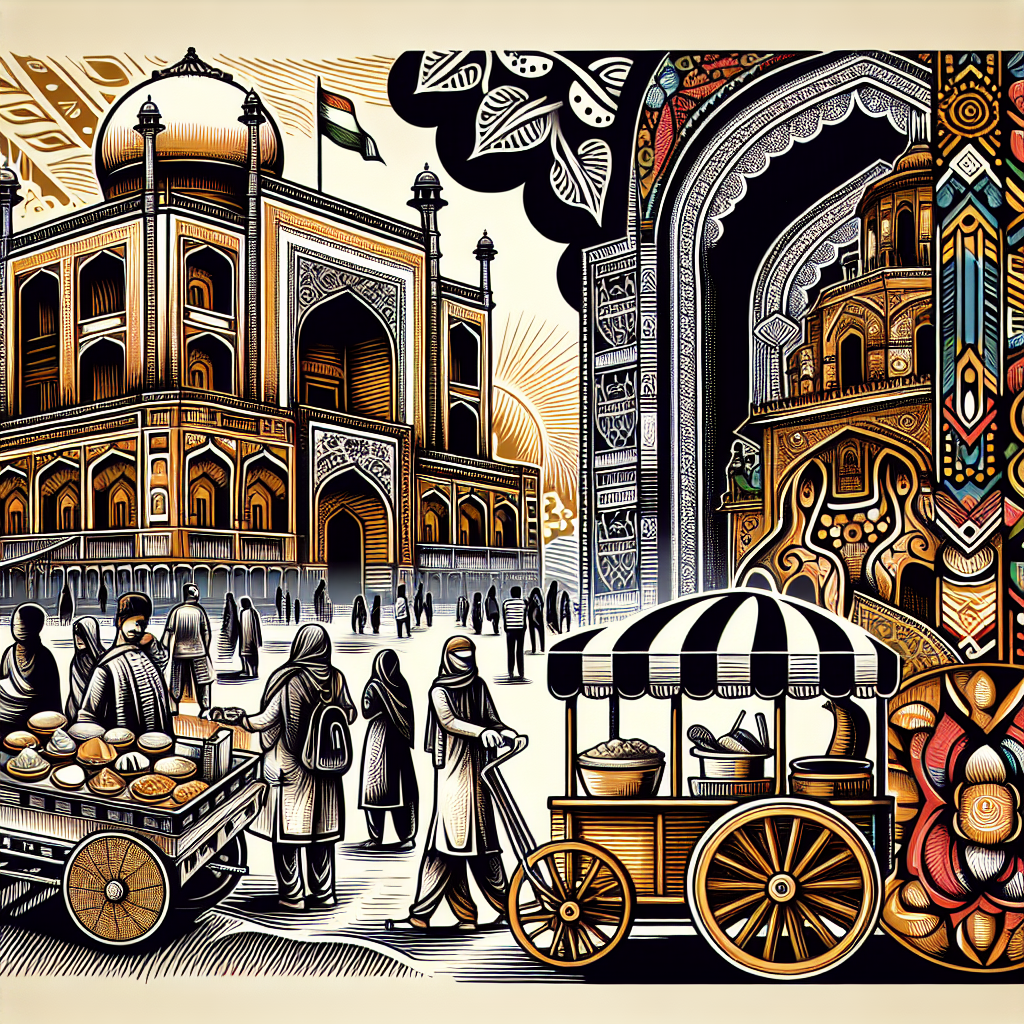

In [20]:
image = artist("New Delhi")
display(image)

##Audio
And let's make a function talker that uses OpenAI's speech model to generate Audio

Troubleshooting Audio issues
If you have any problems running this code below (like a FileNotFound error, or a warning of a missing package), you may need to install FFmpeg, a very popular audio utility.

For PC Users

Download FFmpeg from the official website: https://ffmpeg.org/download.html

Extract the downloaded files to a location on your computer (e.g., C:\ffmpeg)

Add the FFmpeg bin folder to your system PATH:

Right-click on 'This PC' or 'My Computer' and select 'Properties'
Click on 'Advanced system settings'
Click on 'Environment Variables'
Under 'System variables', find and edit 'Path'
Add a new entry with the path to your FFmpeg bin folder (e.g., C:\ffmpeg\bin)
Restart your command prompt, and within Jupyter Lab do Kernel -> Restart kernel, to pick up the changes
Open a new command prompt and run this to make sure it's installed OK ffmpeg -version

In [21]:
from pydub import AudioSegment
from pydub.playback import play

def talker(message):
    response = openai.audio.speech.create(
      model="tts-1",
      voice="onyx",    # Also, try replacing onyx with alloy
      input=message
    )

    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")
    play(audio)

In [22]:
talker("Well, hi there")

##Our Agent Framework
The term 'Agentic AI' and Agentization is an umbrella term that refers to a number of techniques, such as:

Breaking a complex problem into smaller steps, with multiple LLMs carrying out specialized tasks
The ability for LLMs to use Tools to give them additional capabilities
The 'Agent Environment' which allows Agents to collaborate
An LLM can act as the Planner, dividing bigger tasks into smaller ones for the specialists
The concept of an Agent having autonomy / agency, beyond just responding to a prompt - such as Memory
We're showing 1 and 2 here, and to a lesser extent 3 and 5. In week 8 we will do the lot!

In [23]:
def chat(message, history):
    image = None
    conversation = [{"role": "system", "content": system_message}]
    for human, assistant in history:
        conversation.append({"role": "user", "content": human})
        conversation.append({"role": "assistant", "content": assistant})
    conversation.append({"role": "user", "content": message})
    response = openai.chat.completions.create(model=MODEL, messages=conversation, tools=tools)

    if response.choices[0].finish_reason=="tool_calls":
        message = tool_call = response.choices[0].message
        response, city = handle_tool_call(message)
        conversation.append(message)
        conversation.append(response)
        image = artist(city)
        response = openai.chat.completions.create(model=MODEL, messages=conversation)

    reply = response.choices[0].message.content
    talker(reply)
    return reply, image

In [24]:
# More involved Gradio code as we're not using the preset Chat interface

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500)
        image_output = gr.Image(height=500)
    with gr.Row():
        msg = gr.Textbox(label="Chat with our AI Assistant:")
    with gr.Row():
        clear = gr.Button("Clear")

    def user(user_message, history):
        return "", history + [[user_message, None]]

    def bot(history):
        user_message = history[-1][0]
        bot_message, image = chat(user_message, history[:-1])
        history[-1][1] = bot_message
        return history, image

    msg.submit(user, [msg, chatbot], [msg, chatbot], queue=False).then(
        bot, chatbot, [chatbot, image_output]
    )
    clear.click(lambda: None, None, chatbot, queue=False)

ui.launch()

/usr/local/lib/python3.10/dist-packages/gradio/components/chatbot.py:222: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  warnings.warn(


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2b418b2a6062d994fb.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
